In [39]:
import numpy as np  
import matplotlib.pyplot as plt  
import random


In [40]:

# Parámetros globales
N = 1000  # Número de nodos
p_ER = 0.01  # Probabilidad de conexión para Erdős-Rényi
m_BA = 5  # Número de enlaces por nodo en Barabási-Albert
alpha1 = 0.3  # Probabilidad de infección para S
alpha2 = 0.1  # Probabilidad de reinfección para S*
beta = 0.1  # Probabilidad de recuperación
V_values = np.linspace(0, 0.8, 20)  # Fracciones de vacunación

IndexError: arrays used as indices must be of integer (or boolean) type

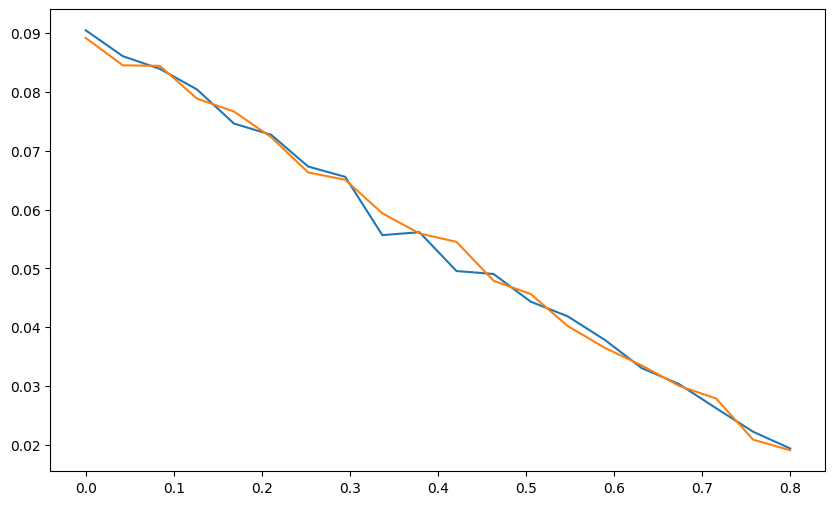

In [41]:

def generate_ER_network(N, p):
    """Genera una red de Erdős-Rényi como matriz de adyacencia."""
    A = np.random.rand(N, N) < p
    np.fill_diagonal(A, 0)  # No hay auto-conexiones
    A = np.triu(A)  # Red simétrica
    return (A + A.T).astype(int)

def generate_BA_network(N, m):
    """Genera una red de Barabási-Albert como matriz de adyacencia."""
    A = np.zeros((N, N), dtype=int)
    targets = list(range(m))  # Primeros nodos conectados
    for node in range(m, N):
        degrees = A.sum(axis=0)
        if degrees.sum() == 0:  # Evitar división por cero
            probs = np.ones(N) / N
        else:
            probs = degrees / degrees.sum()
        new_targets = np.random.choice(np.arange(N), size=m, p=probs, replace=False)
        for t in new_targets:
            A[node, t] = A[t, node] = 1
    return A

# Modelo SIS modificado
def SIS_modified(A, V_fraction, targeted=False):
    """Simula el modelo SIS modificado."""
    N = len(A)
    S = np.ones(N, dtype=int)  # Todos susceptibles inicialmente
    I = np.random.choice(N, size=int(0.1 * N), replace=False)  # 10% infectados
    S[I] = 0
    S_star = np.zeros(N, dtype=int)
    vaccinated = np.zeros(N, dtype=int)

    # Vacunar aleatoriamente o a los hubs
    if targeted:
        degrees = A.sum(axis=0)
        hubs = np.argsort(-degrees)  # Orden descendente
        vaccinated[hubs[:int(V_fraction * N)]] = 1
    else:
        vaccinated[np.random.choice(N, size=int(V_fraction * N), replace=False)] = 1

    # Simulación temporal
    prevalence = []
    for t in range(100):
        new_I = []
        for node in range(N):
            if vaccinated[node]:
                continue
            if S[node] and np.any(A[node, I]) and np.random.rand() < alpha1:
                new_I.append(node)
            elif S_star[node] and np.any(A[node, I]) and np.random.rand() < alpha2:
                new_I.append(node)
        S[I] = 0
        S_star[I] = 1
        I = np.array(new_I)
        S[I] = 0
        S_star[I] = 0
        prevalence.append(len(I) / N)
    return np.mean(prevalence[-20:])  # Promediar últimas iteraciones (estado estacionario)

# Simulación para distintas fracciones de vacunados
def run_simulation(A_generator, name, targeted=False):
    prevalences = []
    for V in V_values:
        A = A_generator(N, p_ER if "ER" in name else m_BA)
        prevalences.append(SIS_modified(A, V, targeted))
    plt.plot(V_values, prevalences, label=f"{name} {'(Targeted)' if targeted else '(Random)'}")

# Ejecutar simulación
plt.figure(figsize=(10, 6))
run_simulation(generate_ER_network, "Erdős-Rényi", targeted=False)
run_simulation(generate_ER_network, "Erdős-Rényi", targeted=True)
run_simulation(generate_BA_network, "Barabási-Albert", targeted=False)
run_simulation(generate_BA_network, "Barabási-Albert", targeted=True)

plt.xlabel("Fracción de vacunados")  # Título del eje x
plt.ylabel("Prevalencia")           # Título del eje y
plt.ylim(0.0, 0.6)                  # Limita el eje y de 0.0 a 0.6
plt.title("Prevalencia de la infección vs Fracción de vacunados")
plt.legend()
plt.grid()
plt.show()